In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F

/home/magorokhoov/pyenv/py310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CNA(nn.Module):
    def __init__(self, in_nc, out_nc, stride=1):
        super().__init__()
        
        self.conv = nn.Conv2d(in_nc, out_nc, 3, stride=stride, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(out_nc)
        self.act = nn.GELU()
    
    def forward(self, x):
        out = self.conv(x)
        out = self.norm(out)
        out = self.act(out)
        
        return out

In [3]:
class UnetBlock(nn.Module):
    def __init__(self, in_nc, inner_nc, out_nc, inner_block=None):
        super().__init__()
        
        self.conv1 = CNA(in_nc, inner_nc, stride=2)
        self.conv2 = CNA(inner_nc, inner_nc)
        self.inner_block = inner_block
        self.conv3 = CNA(inner_nc, inner_nc)
        self.conv_cat = nn.Conv2d(inner_nc+in_nc, out_nc, 3, padding=1)
        
    def forward(self, x):
        _,_,h,w = x.shape
        
        inner = self.conv1(x)
        inner = self.conv2(inner)
        #print(inner.shape)
        if self.inner_block is not None:
            inner = self.inner_block(inner)
        inner = self.conv3(inner)
        
        inner = F.upsample(inner, size=(h,w), mode='bilinear')
        inner = torch.cat((x, inner), axis=1)
        out = self.conv_cat(inner)
        
        return out

In [4]:
class Unet(nn.Module):
    def __init__(self, in_nc=1, nc=32, out_nc=1, num_downs=6):
        super().__init__()
        
        self.cna1 = CNA(in_nc, nc)
        self.cna2 = CNA(nc, nc)
        
        unet_block = None
        for i in range(num_downs-3):
            unet_block = UnetBlock(8*nc, 8*nc, 8*nc, unet_block)
        unet_block = UnetBlock(4*nc, 8*nc, 4*nc, unet_block)
        unet_block = UnetBlock(2*nc, 4*nc, 2*nc, unet_block)
        self.unet_block = UnetBlock(nc, 2*nc, nc, unet_block)
        
        self.cna3 = CNA(nc, nc)
        
        self.conv_last = nn.Conv2d(nc, out_nc, 3, padding=1)

    def forward(self, x):
        out = self.cna1(x)
        out = self.cna2(out)
        out = self.unet_block(out)
        out = self.cna3(out)
        out = self.conv_last(out)
        
        return out

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,  images_directory, masks_directory, transform=None):
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform
        
        self.images_filenames = sorted(os.listdir(self.images_directory))

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.masks_directory, image_filename), cv2.IMREAD_COLOR)[:,:,0:1]
        image = image.astype(np.float32)/255.0
        mask = mask.astype(np.float32)/255.0
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            mask = np.transpose(mask, (2,0,1))
            
            #mask = torch.from_numpy(mask)
        return image, mask

In [7]:
train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.RandomCrop(256, 256),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.Normalize(mean=(1.0, 1.0, 1.0), std=(1.0, 1.0, 1.0)),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.CenterCrop(256, 256),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [8]:
ds_images_path = './segmentation_full_body_mads_dataset_1192_img/images'
ds_masks_path = './segmentation_full_body_mads_dataset_1192_img/masks'

In [9]:
ds_train = MyDataset(ds_images_path, ds_masks_path, transform=train_transform)

In [10]:
#ds_train[0][0].max()

In [11]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        mask = np.transpose(mask, (1,2,0))
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()


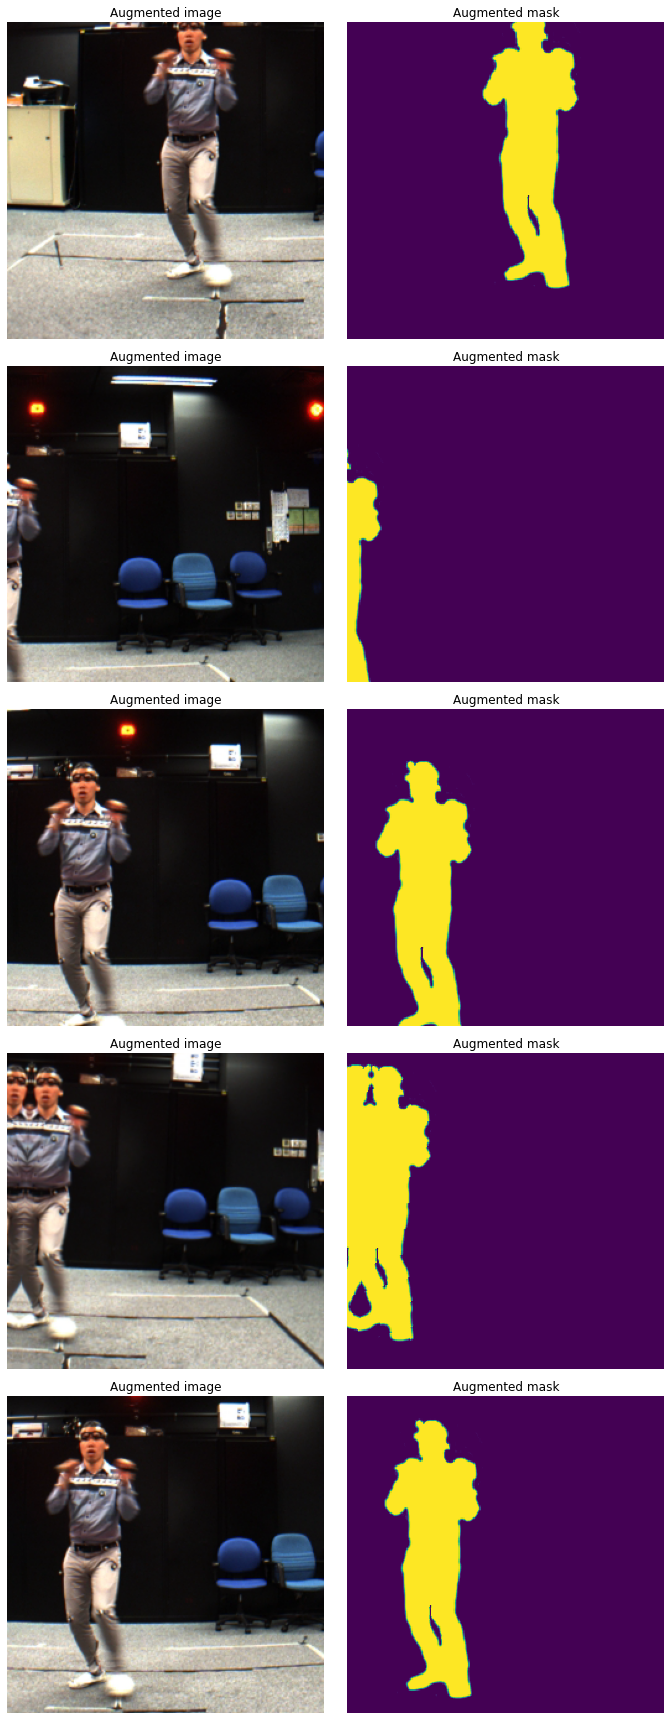

In [12]:
visualize_augmentations(ds_train, 0)

In [13]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    ds_train, shuffle=True, 
    batch_size=batch_size, num_workers=1, drop_last=True
)

device = 'cuda'
unet_model = Unet(in_nc=3, nc=32, out_nc=1, num_downs=5)
unet_model = unet_model.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [14]:
count_parameters(unet_model)

8440481

In [19]:
epochs = 10
for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_loader)):
        img, mask = sample
        img = img.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        
        pred = unet_model(img)
        loss = loss_fn(pred, mask)

        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item

        optimizer.step()
    
    scheduler.step()
    #pbar.set_description(f'loss: {loss_item:.5f}\tlr: {scheduler.get_last_lr}')
    print(f'{loss_val/len(train_loader)}\t lr: {scheduler.get_last_lr()}')
    #print()

100%|███████████████████████████████████████████| 74/74 [00:19<00:00,  3.79it/s]


0.02628248038928251	 lr: [0.00031381059609000004]


100%|███████████████████████████████████████████| 74/74 [00:18<00:00,  3.97it/s]


0.023602846783359308	 lr: [0.00028242953648100003]


 11%|████▊                                       | 8/74 [00:02<00:19,  3.31it/s]


KeyboardInterrupt: 

In [23]:
img = ds_train[10][0].unsqueeze(0)
pred = unet_model(img.cuda())
pred = F.sigmoid(pred.detach()).cpu().numpy()[0].transpose(1,2,0)

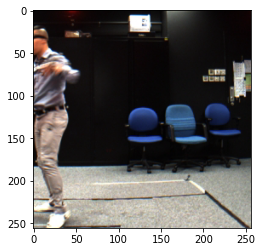

In [24]:
img_np = img.detach().cpu().numpy()[0].transpose(1,2,0)
plt.imshow(img_np)

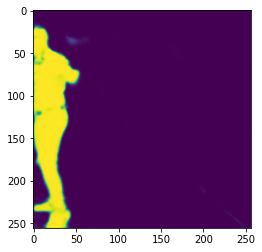

In [25]:
plt.imshow(pred)